In [3]:
from model import * 
from train_model import * 


def pi(s):
    return torch.clamp(s, 0.0, 1.0)

class ExternalWorld:
    def __init__(self, x_values, y_values):
        self.x = torch.tensor(x_values, dtype=torch.float32)
        self.y = torch.tensor(y_values, dtype=torch.int64)
        self.size_dataset = len(self.x)



Epoch 1/1000 | E=0.30 C=0.77163 Error=50.00%:   0%|          | 0/1000 [00:00<?, ?epoch/s]

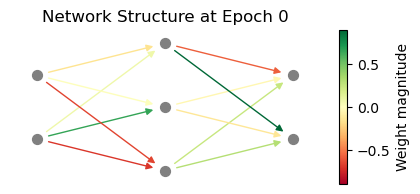

Epoch 250/1000 | E=-0.12 C=0.00000 Error=0.00%:  25%|██▍       | 249/1000 [00:01<00:03, 208.82epoch/s]

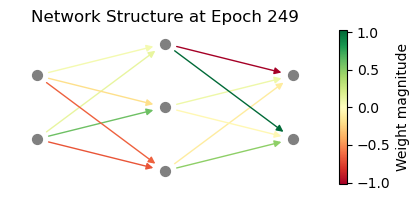

Epoch 500/1000 | E=-0.12 C=0.00000 Error=0.00%:  50%|████▉     | 499/1000 [00:02<00:02, 212.87epoch/s]

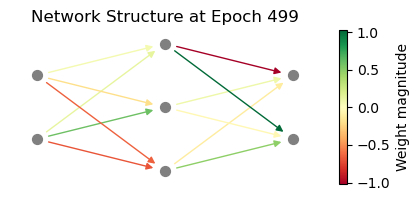

Epoch 750/1000 | E=-0.12 C=0.00000 Error=0.00%:  75%|███████▍  | 749/1000 [00:03<00:01, 214.69epoch/s]

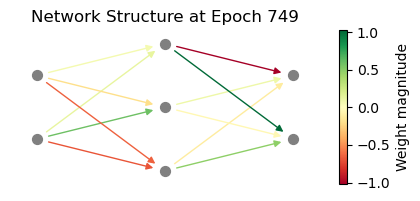

Epoch 1000/1000 | E=-0.12 C=0.00000 Error=0.00%: 100%|█████████▉| 999/1000 [00:04<00:00, 218.66epoch/s]

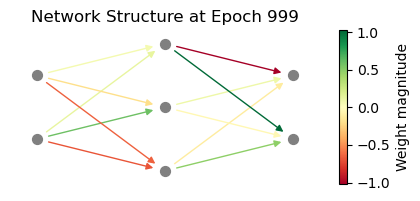

Epoch 1000/1000 | E=-0.12 C=0.00000 Error=0.00%: 100%|██████████| 1000/1000 [00:04<00:00, 200.71epoch/s]


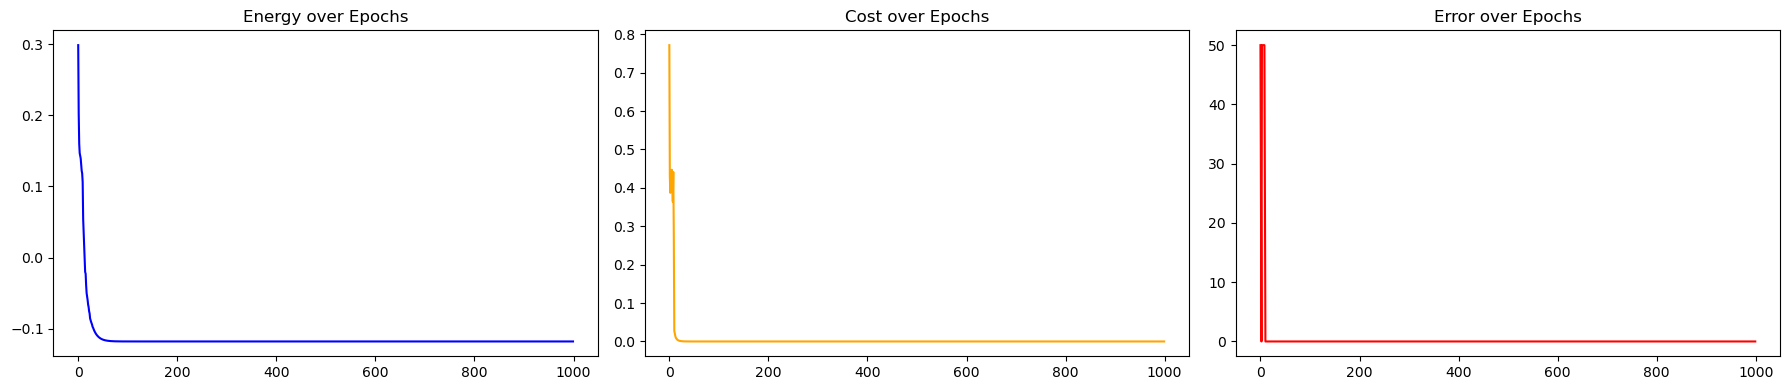

In [27]:
# XOR dataset
xor_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]] * 10, dtype=np.float32)
xor_y = np.array([0, 1, 1, 0] * 10, dtype=np.int64)

# ExternalWorld instance with XOR data
xor_world = ExternalWorld(xor_x, xor_y)

# small nets can solve xor
xor_net = Network(
    name="xor_net",
    external_world=xor_world,
    hyperparameters={
        "hidden_sizes": [3],
        "output_size": 2,
        "batch_size": 4,
        "n_epochs": 1000,
        "n_it_neg": 10,
        "n_it_pos": 10,
        "alphas": [np.float32(0.1), np.float32(0.1),  np.float32(0.05)]
    }
)

# Train the network
train_net(xor_net, plot_graph= True)



In [31]:
class ClampingNetwork(Network):

    # --- Initialization ---
    def initialize_layers(self, clamp_dict, num_layers, batch_size):
        return [self._init_layer(i, clamp_dict, num_layers, batch_size) for i in range(num_layers)]

    def _init_layer(self, i, clamp_dict, num_layers, batch_size):
        if i in clamp_dict:
            return clamp_dict[i].clone()
        elif i == 0:
            return torch.randn(batch_size, self.weights[0].shape[0]) * 0.1
        else:
            return torch.zeros(batch_size, self.weights[i - 1].shape[1])

    # --- Relaxation ---
    def relax_layers(self, current, clamp_dict):
        num_layers = len(current)
        new = [None] * num_layers

        for i in reversed(range(num_layers)):
            new[i] = self._relax_layer(i, current, new, clamp_dict)

            # new[i] = self._relax_layer(i, current, new, clamp_dict)

        return new

    def _relax_layer(self, i, current, new, clamp_dict):
        if i in clamp_dict:
            # print(f"Layer {i} is clamped")
            return clamp_dict[i].clone()

        if i == 0:
            # print(f"Updating layer {i} using: L1")
            return self._update_input_layer(current)

        if i == len(current) - 1:
            # print(f"Updating layer {i} using: L{len(current)-2}")
            return self._update_output_layer(current)

        # print(f"Updating layer {i} using: L{i-1}, L{i+1}")
        return self._update_hidden_layer(i, current, new)




    def _update_input_layer(self, current):
        return self.activation(torch.matmul(current[1], self.weights[0].t()) + self.biases[0])

    def _update_hidden_layer(self, i, current, new):
        return self.activation(
            torch.matmul(current[i - 1], self.weights[i - 1]) +
            torch.matmul(current[i + 1], self.weights[i].t()) +
            self.biases[i]
        )

    def _update_output_layer(self, current):
        return self.activation(torch.matmul(current[-2], self.weights[-1]) + self.biases[-1])

    # --- Parameter Update ---
    def update_parameters(self, original, current, alphas):
        batch_size = original[0].shape[0]
        for i in range(1, len(current)):
            delta = current[i] - original[i]
            self.biases[i] += alphas[i - 1] * delta.mean(dim=0)
            self.weights[i - 1] += alphas[i - 1] * (current[i - 1].T @ delta) / batch_size

    # --- Logging & Plotting ---
    def _log_iteration(self, t, current, original, energy, n_iterations):
        # if t % max(n_iterations // 4, 1) == 0 or t == n_iterations - 1:
        diffs = [torch.norm(current[i] - original[i]).item() for i in range(len(current))]
        # print(f"[Iter {t}] Energy: {energy:.4f} | Δlayer norms: {[round(d, 4) for d in diffs]}")

    def _plot_energy_curve(self, energy_log):
        pass
        # import matplotlib.pyplot as plt
        # plt.plot(energy_log)
        # plt.xlabel("Iteration")
        # plt.ylabel("Energy")
        # plt.title("Energy During Clamped Positive Phase")
        # plt.grid(True)
        # plt.show()

    def _visualize_input_if_mnist(self, current):
        import matplotlib.pyplot as plt
        print(current[-1])
        # if current[0].shape == (1, 784):
        #     plt.imshow(current[0].detach().cpu().view(28, 28), cmap='gray')
        #     plt.title("Relaxed Input")
        #     plt.axis("off")
        #     plt.show()

    # --- Positive Phase Clamp ---
    def positive_phase_clamp(self, n_iterations, clamp_dict, *alphas):
        num_layers = len(self.weights) + 1
        batch_size = next(iter(clamp_dict.values())).shape[0]

        self.layers = self.initialize_layers(clamp_dict, num_layers, batch_size)
        
        original = [layer.clone() for layer in self.layers]
        current = [layer.clone() for layer in self.layers]

        energy_log = []
        for t in range(n_iterations):
            current = self.relax_layers(current, clamp_dict)
            energy = self.energy(current).mean().item()
            energy_log.append(energy)
            self._log_iteration(t, current, original, energy, n_iterations)

        self.update_parameters(original, current, alphas)
        self.layers = current

        self._plot_energy_curve(energy_log)
        self._visualize_input_if_mnist(current)

    def clamp_output(self, y_scaled):
        """Clamp the output layer (last layer) to a target one-hot vector."""
        output_index = len(self.weights)
        return {output_index: y_scaled}



def copy_to_clamping_network(net: Network) -> ClampingNetwork:
    new_net = ClampingNetwork("__copied__" + net.path, net.external_world, net.hyperparameters)
    new_net.weights = [w.clone() for w in net.weights]
    new_net.biases = [b.clone() for b in net.biases]
    new_net.training_curves = net.training_curves.copy()
    new_net.batch_size = net.batch_size
    new_net.dataset_size = net.dataset_size
    new_net.persistent_particles = [p.clone() for p in net.persistent_particles]
    new_net.index = net.index
    if hasattr(net, 'layers'):
        new_net.layers = [l.clone() for l in net.layers]
    return new_net


# Suppose you already trained this:
trained_net = xor_net
# ... do training here ...

# Copy to a clamping-enabled version:


for pair in [[0, 0], [0, 1], [0, 0], [1, 0]]:
    print()
    print("output pair", pair)
    clamp_net = copy_to_clamping_network(trained_net)
    y = torch.tensor(pair, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    clamp_dict = clamp_net.clamp_output(y)
    clamp_net.positive_phase_clamp(
        2000,
        clamp_dict, 
        0.1, 0.1, 0.1
    )





output pair [0, 0]
tensor([[0., 0.]])

output pair [0, 1]
tensor([[0., 1.]])

output pair [0, 0]
tensor([[0., 0.]])

output pair [1, 0]
tensor([[1., 0.]])


In [ ]:


print()
print("output pair", pair)
clamp_net = copy_to_clamping_network(trained_net)
y = torch.tensor(pair, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
clamp_dict = clamp_net.clamp_output(y)
clamp_net.positive_phase_clamp(
    2000,
    clamp_dict, 
    0.1, 0.1, 0.1
)

